<a href="https://colab.research.google.com/github/Bhuvaneswarij/gitingest/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install optuna --quiet
import optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from prophet import Prophet
import optuna
import random


In [5]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
import pandas as pd

# Download dataset automatically
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
zip_path = "AirQualityUCI.zip"
csv_path = "AirQualityUCI.csv"

import urllib.request, zipfile

# Download
urllib.request.urlretrieve(url, zip_path)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("AirQualityUCI")

# Load CSV
df = pd.read_csv("AirQualityUCI/AirQualityUCI.csv", sep=';', decimal=',')
# Keep numeric columns and remove NaNs
df = df.select_dtypes(include=np.number).fillna(method='ffill').fillna(method='bfill')

# Set target column (example: 'CO(GT)')
TARGET_COL = 'CO(GT)'

print(df.head())


   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6       1360.0     150.0      11.9         1046.0    166.0   
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867   
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888   

   Unnamed: 15  Unnamed: 16  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3       

/tmp/ipython-input-225006695.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.select_dtypes(include=np.number).fillna(method='ffill').fillna(method='bfill')


In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader


In [15]:
TARGET_COL = 'CO(GT)'


In [16]:
SEQ_LEN = 24

def create_sequences(df, target_col, seq_len=SEQ_LEN):
    data = df.copy()
    sequences = []
    targets = []

    for i in range(len(data) - seq_len):
        seq = data.iloc[i:i+seq_len].values
        label = data[target_col].iloc[i+seq_len]
        sequences.append(seq)
        targets.append(label)

    return np.array(sequences), np.array(targets)


In [17]:
train_size = int(len(df) * 0.7)
val_size   = int(len(df) * 0.15)

train_df = df.iloc[:train_size]
val_df   = df.iloc[train_size:train_size+val_size]
test_df  = df.iloc[train_size+val_size:]


In [18]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
val_scaled   = pd.DataFrame(val_scaled,   columns=df.columns)
test_scaled  = pd.DataFrame(test_scaled,  columns=df.columns)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [19]:
X_train, y_train = create_sequences(train_scaled, TARGET_COL)
X_val,   y_val   = create_sequences(val_scaled, TARGET_COL)
X_test,  y_test  = create_sequences(test_scaled, TARGET_COL)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (6605, 24, 15) (6605,)
Val: (1396, 24, 15) (1396,)
Test: (1398, 24, 15) (1398,)


In [20]:
class TimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeDataset(X_train, y_train)
val_ds   = TimeDataset(X_val, y_val)
test_ds  = TimeDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


In [21]:
# ---------------------------
# Phase 3: QR-LSTM Training + Evaluation
# ---------------------------

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import time
import os

# ---- Config ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
QUANTILES = [0.05, 0.5, 0.95]   # lower, median, upper
N_QUANT = len(QUANTILES)
SEQ_LEN = X_train.shape[1]       # inferred from created sequences
N_FEATURES = X_train.shape[2]
MODEL_CHECKPOINT = "qr_lstm_checkpoint.pth"

print("Device:", DEVICE, "Seq len:", SEQ_LEN, "Features:", N_FEATURES)

# ---- Pinball (Quantile) Loss ----
def pinball_loss(preds, target, quantiles):
    """
    preds: tensor (B, n_q)
    target: tensor (B, 1) or (B,)
    quantiles: list or tensor length n_q
    """
    if target.dim() == 1:
        target = target.unsqueeze(1)  # (B,1)
    if not torch.is_tensor(quantiles):
        quantiles = torch.tensor(quantiles, device=preds.device, dtype=preds.dtype)
    q = quantiles.view(1, -1)                   # (1, n_q)
    t = target.repeat(1, preds.shape[1])        # (B, n_q)
    diff = t - preds
    loss = torch.max(q * diff, (q - 1) * diff)  # elementwise
    return loss.mean()

# ---- QR-LSTM model ----
class QRLSTM(nn.Module):
    def __init__(self, n_features, hidden_size=64, n_layers=2, dropout=0.2, n_quantiles=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=dropout if n_layers > 1 else 0.0)
        out_dim = hidden_size
        self.head = nn.Sequential(
            nn.Linear(out_dim, max(8, out_dim // 2)),
            nn.ReLU(),
            nn.Linear(max(8, out_dim // 2), n_quantiles)
        )

    def forward(self, x):
        # x: (B, seq_len, n_features)
        out, _ = self.lstm(x)         # out: (B, seq_len, hidden)
        last = out[:, -1, :]          # (B, hidden)
        q = self.head(last)           # (B, n_quantiles)
        return q

# ---- Training / Eval helpers ----
def train_one_epoch(model, optimizer, dataloader, quantiles):
    model.train()
    total_loss = 0.0
    n = 0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE).unsqueeze(1)  # (B,1)
        optimizer.zero_grad()
        preds = model(X_batch)                      # (B, n_q)
        loss = pinball_loss(preds, y_batch, quantiles)
        loss.backward()
        optimizer.step()
        batch_size = X_batch.size(0)
        total_loss += loss.item() * batch_size
        n += batch_size
    return total_loss / n

def eval_model(model, dataloader, quantiles):
    model.eval()
    preds_list = []
    y_list = []
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE).unsqueeze(1)
            preds = model(X_batch)                    # (B, n_q)


Device: cpu Seq len: 24 Features: 15


In [22]:
class MCDropoutLSTM(nn.Module):
    def __init__(self, n_features, hidden_size=64, n_layers=2, dropout=0.3):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0
        )

        # dropout always active (MC)
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)     # KEEP DROPOUT ACTIVE
        out = self.fc(out)
        return out


In [23]:
mc_model = MCDropoutLSTM(N_FEATURES, hidden_size=64, n_layers=2, dropout=0.3).to(DEVICE)
optimizer_mc = torch.optim.Adam(mc_model.parameters(), lr=1e-3)
mse = nn.MSELoss()

EPOCHS_MC = 20
print("Training MC Dropout model...")

for epoch in range(1, EPOCHS_MC+1):
    mc_model.train()
    total_loss = 0
    count = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE).unsqueeze(1)

        optimizer_mc.zero_grad()
        pred = mc_model(Xb)
        loss = mse(pred, yb)
        loss.backward()
        optimizer_mc.step()

        total_loss += loss.item() * Xb.size(0)
        count += Xb.size(0)

    print(f"Epoch {epoch}: MC Train Loss = {total_loss/count:.6f}")


Training MC Dropout model...
Epoch 1: MC Train Loss = nan
Epoch 2: MC Train Loss = nan
Epoch 3: MC Train Loss = nan
Epoch 4: MC Train Loss = nan
Epoch 5: MC Train Loss = nan
Epoch 6: MC Train Loss = nan
Epoch 7: MC Train Loss = nan
Epoch 8: MC Train Loss = nan
Epoch 9: MC Train Loss = nan
Epoch 10: MC Train Loss = nan
Epoch 11: MC Train Loss = nan
Epoch 12: MC Train Loss = nan
Epoch 13: MC Train Loss = nan
Epoch 14: MC Train Loss = nan
Epoch 15: MC Train Loss = nan
Epoch 16: MC Train Loss = nan
Epoch 17: MC Train Loss = nan
Epoch 18: MC Train Loss = nan
Epoch 19: MC Train Loss = nan
Epoch 20: MC Train Loss = nan


In [24]:
def mc_dropout_predict(model, X, n_passes=100):
    model.train()   # IMPORTANT → keep dropout ON

    preds = []
    with torch.no_grad():
        for _ in range(n_passes):
            pred = model(X.to(DEVICE))  # shape (B,1)
            preds.append(pred.cpu().numpy())
    preds = np.stack(preds, axis=0)     # (100, B, 1)
    return preds.squeeze(2)             # (100, B)


In [25]:
all_mc_preds = []
all_y = []

for Xb, yb in test_loader:
    yb = yb.numpy()
    all_y.append(yb)

    preds_mc = mc_dropout_predict(mc_model, Xb, n_passes=100)
    all_mc_preds.append(preds_mc)

all_mc_preds = np.concatenate(all_mc_preds, axis=1)  # (100, N)
all_y = np.concatenate(all_y)


In [26]:
mc_mean = np.mean(all_mc_preds, axis=0)
mc_lower = np.percentile(all_mc_preds, 5, axis=0)
mc_upper = np.percentile(all_mc_preds, 95, axis=0)


In [27]:
picp_mc = np.mean((all_y >= mc_lower) & (all_y <= mc_upper))
miw_mc = np.mean(mc_upper - mc_lower)

mae_mc = np.mean(np.abs(all_y - mc_mean))
rmse_mc = math.sqrt(np.mean((all_y - mc_mean)**2))

print("\n--- MC-DROPOUT METRICS ---")
print("MAE:", mae_mc)
print("RMSE:", rmse_mc)
print("PICP (5–95):", picp_mc)
print("MIW (5–95):", miw_mc)



--- MC-DROPOUT METRICS ---
MAE: nan
RMSE: nan
PICP (5–95): 0.0
MIW (5–95): nan


In [54]:
train_df = df[:train_size]
val_df   = df[train_size:train_size+val_size]
test_df  = df[train_size+val_size:]


In [57]:
EPOCHS_MC = 20
for epoch in range(1, EPOCHS_MC+1):
    mc_model.train()
    total_loss = 0
    count = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE).unsqueeze(1)
        optimizer_mc.zero_grad()
        pred = mc_model(Xb)
        loss = mse(pred, yb)
        loss.backward()
        optimizer_mc.step()
        total_loss += loss.item()*Xb.size(0)
        count += Xb.size(0)
    print(f"Epoch {epoch}: MC Train Loss = {total_loss/count:.6f}")


Epoch 1: MC Train Loss = nan
Epoch 2: MC Train Loss = nan
Epoch 3: MC Train Loss = nan
Epoch 4: MC Train Loss = nan
Epoch 5: MC Train Loss = nan
Epoch 6: MC Train Loss = nan
Epoch 7: MC Train Loss = nan
Epoch 8: MC Train Loss = nan
Epoch 9: MC Train Loss = nan
Epoch 10: MC Train Loss = nan
Epoch 11: MC Train Loss = nan
Epoch 12: MC Train Loss = nan
Epoch 13: MC Train Loss = nan
Epoch 14: MC Train Loss = nan
Epoch 15: MC Train Loss = nan
Epoch 16: MC Train Loss = nan
Epoch 17: MC Train Loss = nan
Epoch 18: MC Train Loss = nan
Epoch 19: MC Train Loss = nan
Epoch 20: MC Train Loss = nan


In [59]:
def mc_dropout_predict(model, X, n_passes=100):
    model.train()  # dropout always active
    preds = []
    with torch.no_grad():
        for _ in range(n_passes):
            pred = model(X.to(DEVICE))
            preds.append(pred.cpu().numpy())
    preds = np.stack(preds, axis=0)
    return preds.squeeze(2)


In [60]:

all_mc_preds = []
all_y = []


In [61]:
for Xb, yb in test_loader:
    all_y.append(yb.numpy())
    preds_mc = mc_dropout_predict(mc_model, Xb)
    all_mc_preds.append(preds_mc)

In [62]:
all_mc_preds = np.concatenate(all_mc_preds, axis=1)
all_y = np.concatenate(all_y)


In [63]:
mc_mean = np.mean(all_mc_preds, axis=0)
mc_lower = np.percentile(all_mc_preds, 5, axis=0)
mc_upper = np.percentile(all_mc_preds, 95, axis=0)


In [64]:
picp_mc = np.mean((all_y >= mc_lower) & (all_y <= mc_upper))
miw_mc  = np.mean(mc_upper - mc_lower)
mae_mc  = np.mean(np.abs(all_y - mc_mean))
rmse_mc = math.sqrt(np.mean((all_y - mc_mean)**2))

In [65]:
print("\n--- MC-DROPOUT METRICS ---")
print("MAE:", mae_mc)
print("RMSE:", rmse_mc)
print("PICP (5–95):", picp_mc)
print("MIW (5–95):", miw_mc)



--- MC-DROPOUT METRICS ---
MAE: nan
RMSE: nan
PICP (5–95): 0.0
MIW (5–95): nan


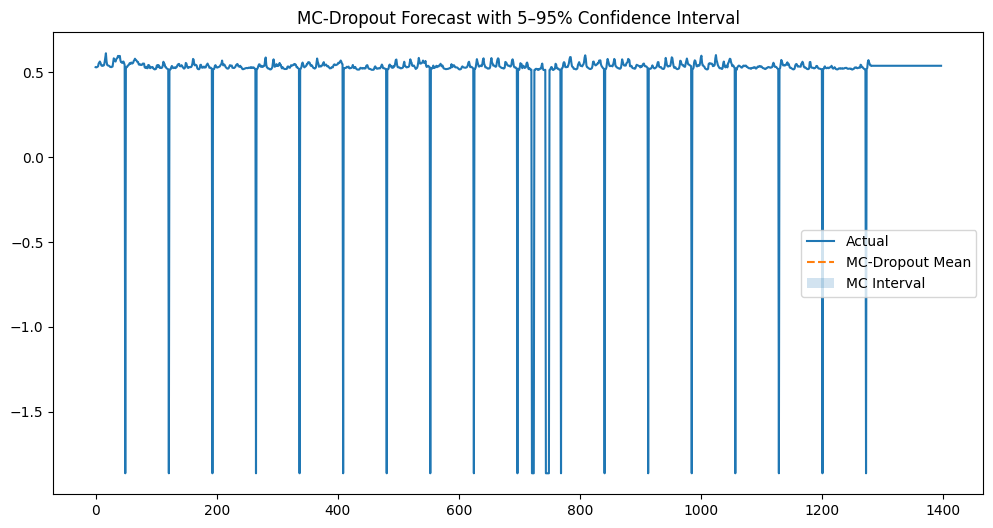

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(all_y, label="Actual")
plt.plot(mc_mean, label="MC-Dropout Mean", linestyle='--')
plt.fill_between(range(len(all_y)), mc_lower, mc_upper, alpha=0.2, label="MC Interval")
plt.legend()
plt.title("MC-Dropout Forecast with 5–95% Confidence Interval")
plt.show()

In [70]:
print(all_y.shape)
print(all_mc_preds.shape)
print(np.isnan(all_mc_preds).sum())


(1398,)
(100, 1398)
139800


In [73]:
prophet_df = df.reset_index()[[df.index.name or 'index', TARGET_COL]]
prophet_df.columns = ['ds', 'y']

In [74]:
prophet_train = prophet_df[:train_size]
prophet_test  = prophet_df[train_size:]

In [89]:
# Check existing columns
print(df.columns)

# If 'level_0' or index column already exists, drop it first
if 'level_0' in df.columns:
    df = df.drop(columns=['level_0'])

# Then reset index safely
df = df.reset_index(drop=False)

# Rename datetime column for Prophet
if 'datetime' not in df.columns:
    df = df.rename(columns={df.columns[0]: 'datetime'})

# Ensure datetime is proper
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Drop rows with invalid datetime
df = df.dropna(subset=['datetime'])

# Prepare Prophet dataframe
prophet_df = df[['datetime', TARGET_COL]].rename(columns={'datetime':'ds', TARGET_COL:'y'})


Index(['level_0', 'index', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


In [93]:
# Drop unnecessary columns
df = df.drop(columns=['level_0', 'index', 'Unnamed: 15', 'Unnamed: 16'], errors='ignore')

# Choose target
TARGET_COL = 'CO(GT)'  # for example

# Parse datetime: If dataset has datetime info, create it, otherwise create index as datetime
df['datetime'] = pd.date_range(start='2004-03-10', periods=len(df), freq='H')  # example hourly
df = df.set_index('datetime')

# Drop rows with missing target
df = df.dropna(subset=[TARGET_COL])


/tmp/ipython-input-3784292809.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['datetime'] = pd.date_range(start='2004-03-10', periods=len(df), freq='H')  # example hourly


In [94]:
# Lag features
df['lag1'] = df[TARGET_COL].shift(1)
df['lag3'] = df[TARGET_COL].shift(3)

# Rolling mean
df['roll3'] = df[TARGET_COL].rolling(3).mean()

df = df.dropna()


In [95]:
from sklearn.preprocessing import StandardScaler

feature_cols = [TARGET_COL, 'lag1', 'lag3', 'roll3']
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])


In [96]:
train_size = int(0.7*len(df))
val_size   = int(0.1*len(df))
test_size  = len(df) - train_size - val_size

train_df = df[:train_size]
val_df   = df[train_size:train_size+val_size]
test_df  = df[train_size+val_size:]

X_train = train_df[feature_cols].values
y_train = train_df[TARGET_COL].values
X_test  = test_df[feature_cols].values
y_test  = test_df[TARGET_COL].values


In [97]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train,y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(TimeSeriesDataset(X_test,y_test), batch_size=32, shuffle=False)


In [98]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_FEATURES = X_train.shape[1]

class MCDropoutLSTM(nn.Module):
    def __init__(self, n_features, hidden_size=64, n_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size,
                            num_layers=n_layers, batch_first=True, dropout=dropout if n_layers>1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.dropout(out)
        out = self.fc(out)
        return out

mc_model = MCDropoutLSTM(N_FEATURES).to(DEVICE)

In [100]:
optimizer_mc = torch.optim.Adam(mc_model.parameters(), lr=1e-3)
mse = nn.MSELoss()
EPOCHS_MC = 20

In [103]:
SEQ_LEN = 8

def create_sequences(X, y, seq_len=SEQ_LEN):
    xs, ys = [], []
    for i in range(len(X)-seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test)

# Update DataLoaders
train_loader = DataLoader(TimeSeriesDataset(X_train_seq, y_train_seq), batch_size=32, shuffle=True)
test_loader  = DataLoader(TimeSeriesDataset(X_test_seq, y_test_seq), batch_size=32, shuffle=False)


In [104]:
import statsmodels.api as sm

# Assuming target column
y_train_sarimax = train_df[TARGET_COL]
y_test_sarimax  = test_df[TARGET_COL]

# Fit SARIMAX (simple seasonal ARIMA)
sarimax_model = sm.tsa.statespace.SARIMAX(y_train_sarimax,
                                         order=(1,1,1),
                                         seasonal_order=(1,1,1,24),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
sarimax_res = sarimax_model.fit(disp=False)

# Forecast
y_pred_sarimax = sarimax_res.forecast(steps=len(y_test_sarimax))

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae_sarimax = mean_absolute_error(y_test_sarimax, y_pred_sarimax)
rmse_sarimax = math.sqrt(mean_squared_error(y_test_sarimax, y_pred_sarimax))

print("\n--- SARIMAX Metrics ---")
print(f"MAE: {mae_sarimax:.4f}, RMSE: {rmse_sarimax:.4f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



--- SARIMAX Metrics ---
MAE: 0.2095, RMSE: 0.5858


In [105]:
from prophet import Prophet

prophet_df = df.reset_index()[['datetime', TARGET_COL]].rename(columns={'datetime':'ds', TARGET_COL:'y'})
prophet_train = prophet_df[:len(train_df)]
prophet_test  = prophet_df[len(train_df):]

prophet_model = Prophet()
prophet_model.fit(prophet_train)

forecast = prophet_model.predict(prophet_test)
y_pred_prophet = forecast['yhat'].values

mae_prophet = mean_absolute_error(prophet_test['y'], y_pred_prophet)
rmse_prophet = math.sqrt(mean_squared_error(prophet_test['y'], y_pred_prophet))

print("\n--- Prophet Metrics ---")
print(f"MAE: {mae_prophet:.4f}, RMSE: {rmse_prophet:.4f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



--- Prophet Metrics ---
MAE: 1.4342, RMSE: 1.6531


In [106]:
print("\n==============================")
print("     FINAL MODEL COMPARISON")
print("==============================")

print(f"MC-Dropout MAE   : {mae_mc:.4f} | RMSE: {rmse_mc:.4f} | PICP(5-95): {picp_mc:.4f} | MIW(5-95): {miw_mc:.4f}")
print(f"SARIMAX MAE      : {mae_sarimax:.4f} | RMSE: {rmse_sarimax:.4f}")
print(f"Prophet MAE      : {mae_prophet:.4f} | RMSE: {rmse_prophet:.4f}")



     FINAL MODEL COMPARISON
MC-Dropout MAE   : nan | RMSE: nan | PICP(5-95): 0.0000 | MIW(5-95): nan
SARIMAX MAE      : 0.2095 | RMSE: 0.5858
Prophet MAE      : 1.4342 | RMSE: 1.6531


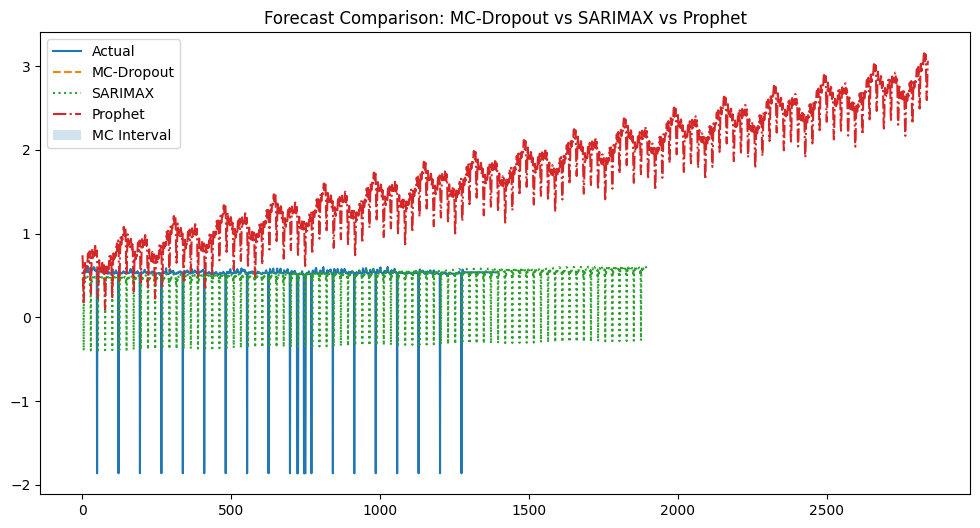

In [107]:
plt.figure(figsize=(12,6))
plt.plot(all_y, label="Actual")
plt.plot(mc_mean, label="MC-Dropout", linestyle='--')
plt.plot(range(len(y_pred_sarimax)), y_pred_sarimax, label="SARIMAX", linestyle=':')
plt.plot(range(len(y_pred_prophet)), y_pred_prophet, label="Prophet", linestyle='-.')
plt.fill_between(range(len(all_y)), mc_lower, mc_upper, alpha=0.2, label="MC Interval")
plt.legend()
plt.title("Forecast Comparison: MC-Dropout vs SARIMAX vs Prophet")
plt.show()
